# Definition
**popularity:** ratio of positive reviews over the total number of reviews toward a subject. (How much are they liked?)

**fame:** number of revews towards a subject. (How many people know them?)

# Load datasets

In [1]:
# Necessary libraries import
import pandas as pd
import numpy as np

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set(style="darkgrid")

In [2]:
# This discards edges than have the same source and destination. 
# In practice, it removes only edges in the wikipedia dataset.
def drop_duplicate_edge(df):
    df.drop_duplicates(subset=['FromNodeId', 'ToNodeId'], inplace=True)

# Read one of epinions or slashdot dataset, given the path.
def read_preprocessed_data(path, with_date):
    # The file is tab-separated and comments are marked with `#`
    # The header is actually a comment in the file, so we give it directly to read_csv
    columns = ['FromNodeId', 'ToNodeId', 'Sign']
    date = []
    if with_date:
        date.append('Date')
    df = pd.read_csv(path, sep='\t', comment='#', names=columns + date, parse_dates=date)
    drop_duplicate_edge(df)
    return df

epinions_df = read_preprocessed_data('data/soc-sign-epinions.txt', with_date=True)
slashdot_df = read_preprocessed_data('data/soc-sign-Slashdot090221.txt', with_date=False)
# Check that epinions was read correctly
epinions_df.head()

,FromNodeId,ToNodeId,Sign,Date
0,3287060356,232085,-1,2001-01-10
1,3288305540,709420,1,2001-01-10
2,3290337156,204418,-1,2001-01-10
3,3294138244,269243,-1,2001-01-10
4,3294138244,170692484,-1,2001-01-10


In [3]:
# Check that slashdot was read correctly
slashdot_df.head()

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


In [4]:
# Read and parse wikipedia dataset to be in the same format than the other two datasets
def parse_wiki(path):
    data = []
    # Ignore the encoding errors, as they are in usernames or other data that are not interesting to us
    with open(path, 'r', encoding='utf-8', errors='ignore') as fp:
        toNodeId = None  # Target of the elecion
        date = None
        for line in fp:
            if line.startswith('#'):  # Ignore comments
                continue
            splt = line.strip().split('\t')
            if   splt[0] == 'U':  # New target of the election
                toNodeId = int(splt[1])
            elif splt[0] == 'T':  # Date of the election
                date = pd.to_datetime(splt[1])
            elif splt[0] == 'V':  # New vote
                fromId = int(splt[2])
                vote = int(splt[1])
                if vote == 0:  # Drop netural votes, as they are not used in the paper
                    continue
                edge = (fromId, toNodeId, vote, date)
                data.append(edge)
    # Create a dataframe from the constructed edges
    df = pd.DataFrame(data, columns=['FromNodeId', 'ToNodeId', 'Sign', 'Date'])
    drop_duplicate_edge(df)
    return df

wikipedia_df = parse_wiki('data/wikiElec.ElecBs3.txt')
wikipedia_df.head()

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-21 01:15:53
1,25,30,-1,2004-09-21 01:15:53
2,4,30,1,2004-09-21 01:15:53
3,5,30,1,2004-09-21 01:15:53
4,6,30,1,2004-09-21 01:15:53


In [5]:
# Store the datasets into datastructures that can hold other attributes too
wikipedia = {'df': wikipedia_df, 'name': 'Wikipedia'}
epinions = {'df': epinions_df, 'name': 'Epinions'}
slashdot = {'df': slashdot_df, 'name': 'Slashdot'}
datasets = [wikipedia, epinions, slashdot]
dated_datasets = [wikipedia, epinions]

# Part 1: Popularity with respect to fame

This first part focus on inner edges. How a user is considered by other users ?  

 For our analysis, several concept as defines as follows:  

* the `fame`: the number of inner edges a user get positive and negative links.
* the `popularity`: the proportion ratio of positive inner linked a user received over the total inner edges

The popularity close to 0 means that the user received almost negative votes while a popularity close to 1 means the user received almost positive votes. This result should puts in perspective with the total number of votes for a specific node.



In [6]:
def fame_and_popularity(df):
    df = df.groupby(['ToNodeId', 'Sign']).count()#.reset_index()
    df = pd.pivot_table(df, index='ToNodeId', values='FromNodeId', columns=['Sign'], fill_value=0)
    df.columns.name = None
    df['fame'] = df[-1] + df[1]
    df['popularity'] = df[1] / (df[-1] + df[1])
    return df

for dataset in datasets:
    dataset['fame_pop'] = fame_and_popularity(dataset['df'])

The first thing to do is to analyse the distribution of `fame`and `popularity`avec the 3 datasets.

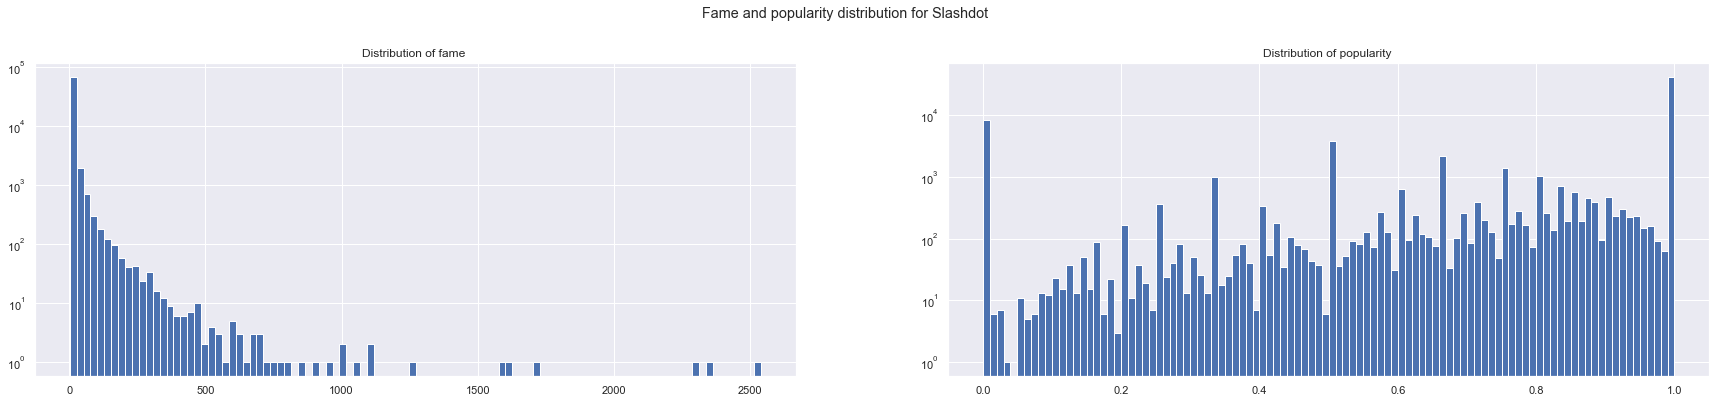

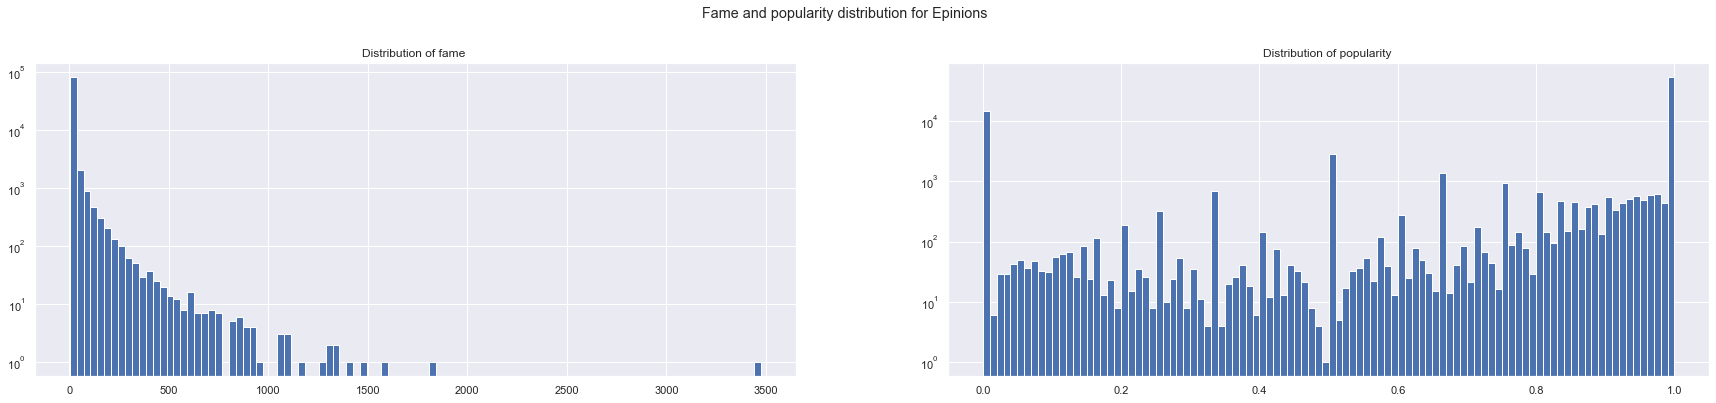

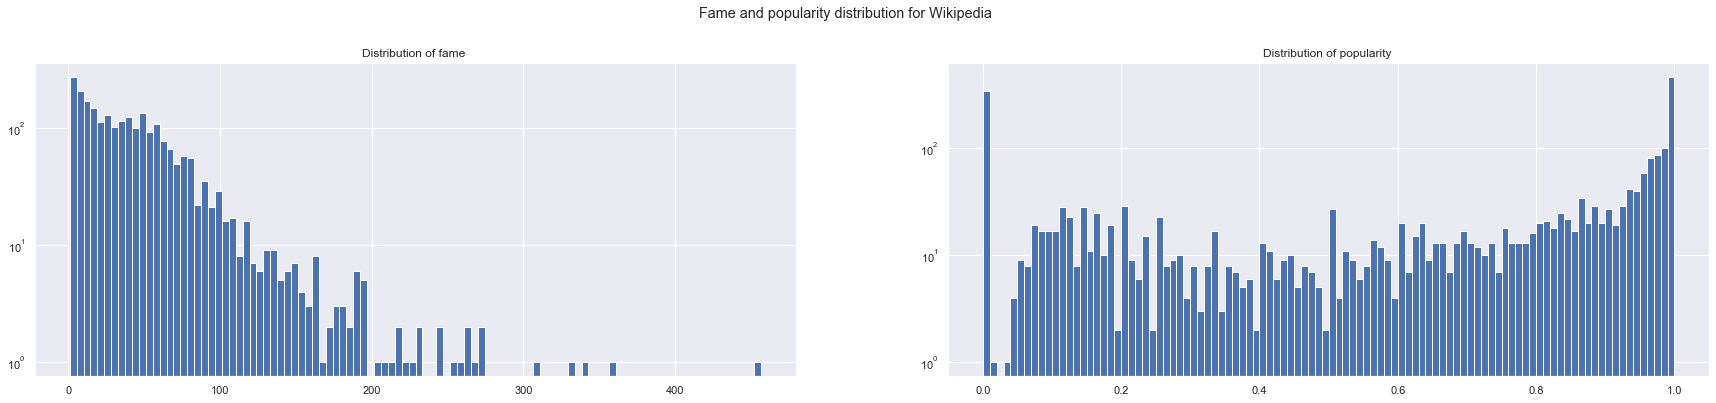

In [7]:
def plot_fame_and_pop(dataset):
    fame_and_pop = dataset['fame_pop']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,6))
    fig.suptitle(f'Fame and popularity distribution for {dataset["name"]}')

    ax1.hist(data=fame_and_pop, x='fame', bins=100)
    ax1.set_title("Distribution of fame ")
    ax1.set_yscale('log')

    ax2.hist(data=fame_and_pop, x='popularity', bins=100)
    ax2.set_title("Distribution of popularity ")
    ax2.set_yscale('log')


    plt.subplots_adjust(top = 0.85, hspace=0.5)
    plt.show()
plot_fame_and_pop(slashdot)
plot_fame_and_pop(epinions)
plot_fame_and_pop(wikipedia)

**Note:**   
- `Slashdot`and `Epinions`: fame distribution seems to follow a power low distribution  
- `Wikipedia`: fame distribution seems to follow a linear trend  

This first result can be justify by the aim of each website. Indeed, `Shashdot` and `Epinions` work as classical social media, where people votes and follows famous people who would like to be famous. This phenomenon correspond to the social media theorie in data science. However `Wikipedia` voting system  is intern to administrator network. The network is structured differently because administrator votes in a more rationnal way.  
=> **social impression**

- For each dataset, there are a lots of 1 values for `fame`  

This correspond to a specific class of user that receive only 1 vote: for `Slashdot`and `Epinions` this could correspond to users who observes only other users without posting anything, or rare people that are almost not follows at all (receive one vote). For `wikipedia`, these people could correspond to voters received almost neutral votes or few people votes for them (maybe at the begining).  
=> **shadow people**

- The `popularity` distribution gives us a very sparse result with a light trend to positive popularity (more values close to 1)
- Many 0 and 1 values fro each dataset  

The sparse result of the distribution is for now difficult to analyse and conclude to relevant results. The number of outliers values are linked to the remark above on `fame`. The user with 0 and 1 popularity is most likely people which received low number of votes (low fame) with popularity of 0 of it received a negative link and a popularity of 1 if the it received positive link.

**TO DO:**  
* plot distribution on distribution chart
* analyse the profile of people with 0 frame to confirm the above hypothesis 
* seperate low votes user to extract real popular user

In [8]:
#With ouliers
from numpy.random import power

def plot_power_law(dataset, df_name, a):
    fame_and_pop = dataset[df_name]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,6))
    fig.suptitle(f'Fame and popularity distribution for {dataset["name"]}')

    count, bins, ignored = ax1.hist(data=fame_and_pop, x='fame', bins=100)
    ax1.set_title("Distribution of fame ")
    ax1.set_yscale('log')
    
    samples = len(fame_and_pop['fame'])
    s = np.random.power(a, samples)
    x = np.linspace(1, fame_and_pop['fame'].max(), 500)
    y = a*x**(-a-1)
    normed_y = samples*np.diff(bins)[0]*y
    ax1.plot(x,normed_y,label='Power law calibrated to  empirical density')

    ax2.hist(data=fame_and_pop, x='popularity', bins=100)
    ax2.set_title("Distribution of popularity ")
    ax2.set_yscale('log')


    plt.subplots_adjust(top = 0.85, hspace=0.5)
    plt.show()


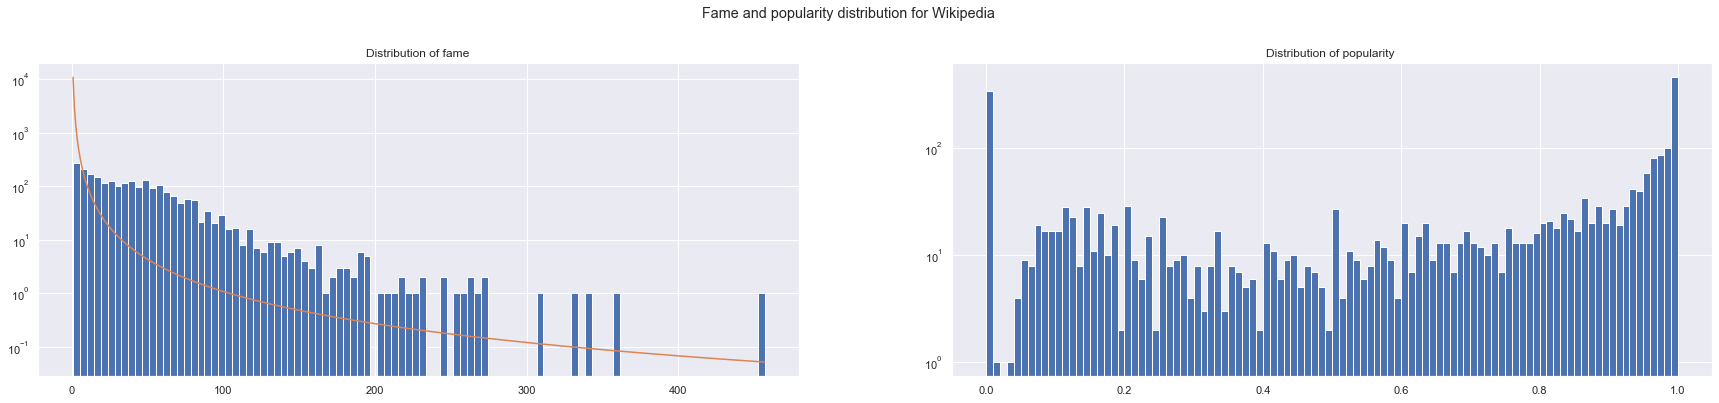

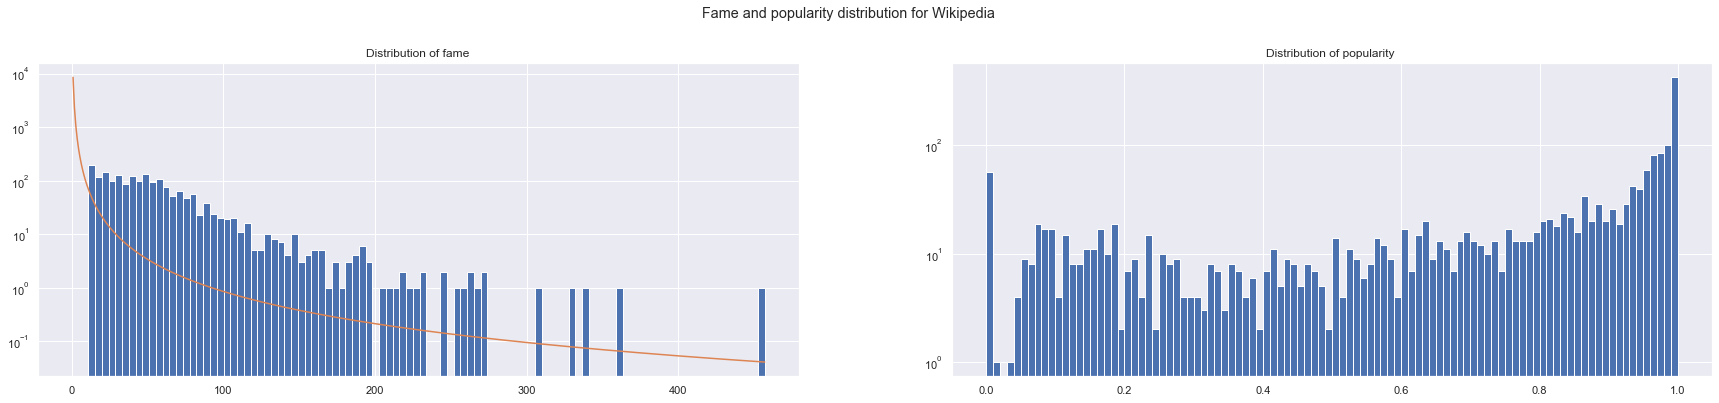

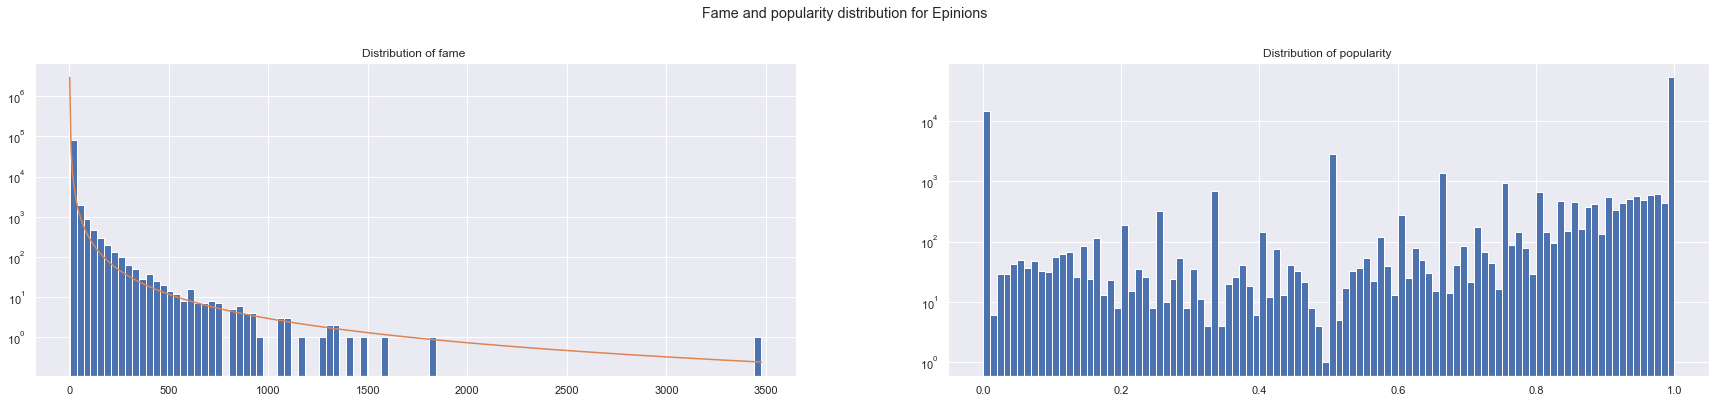

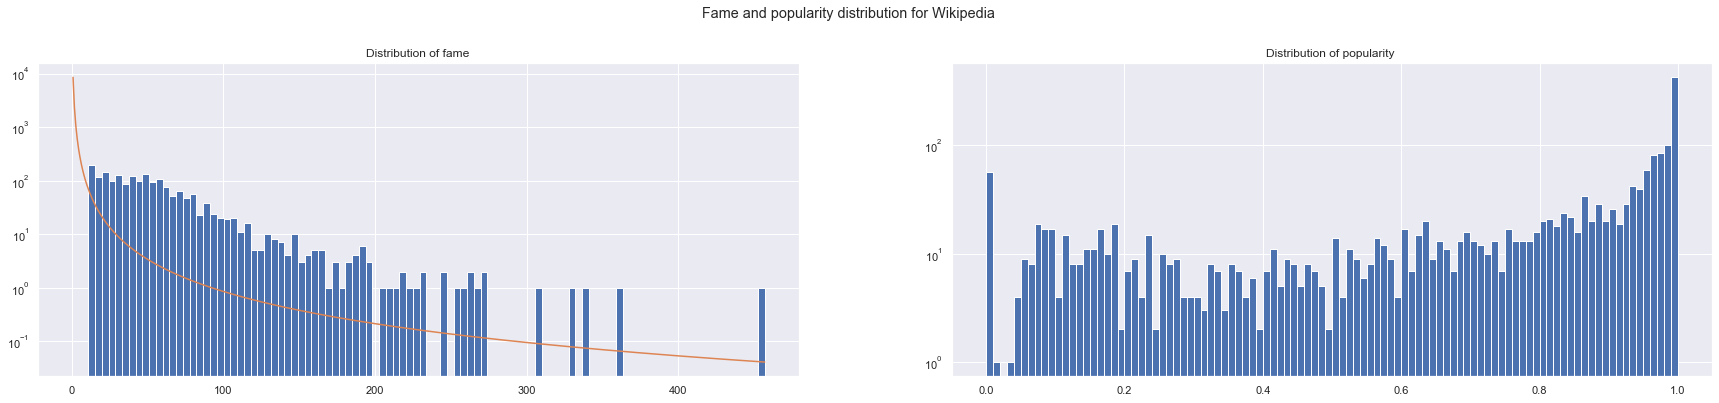

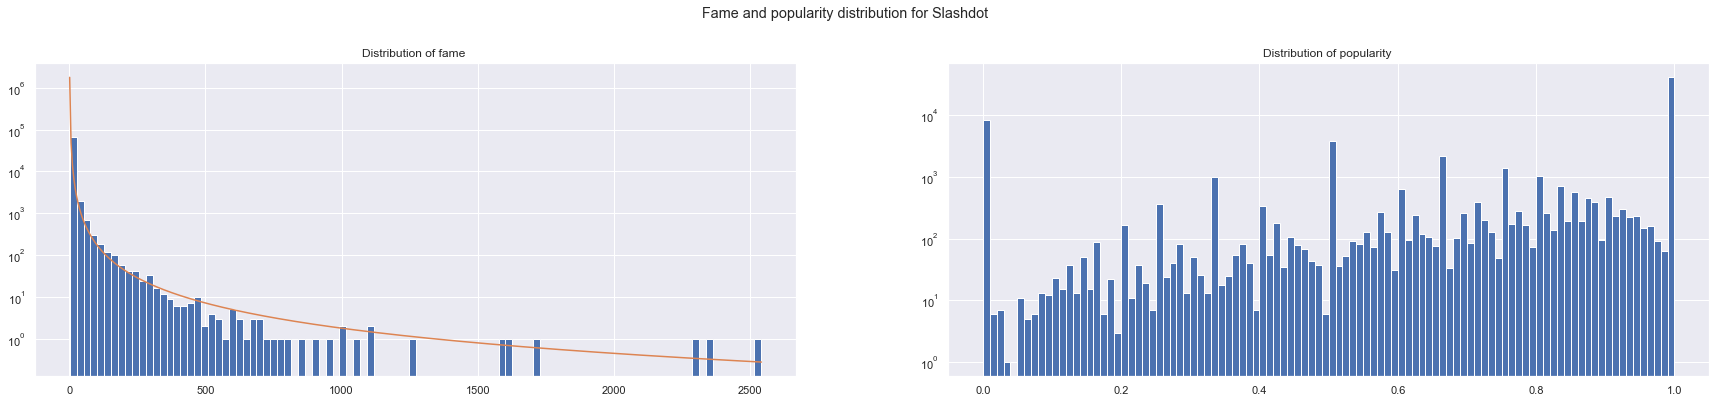

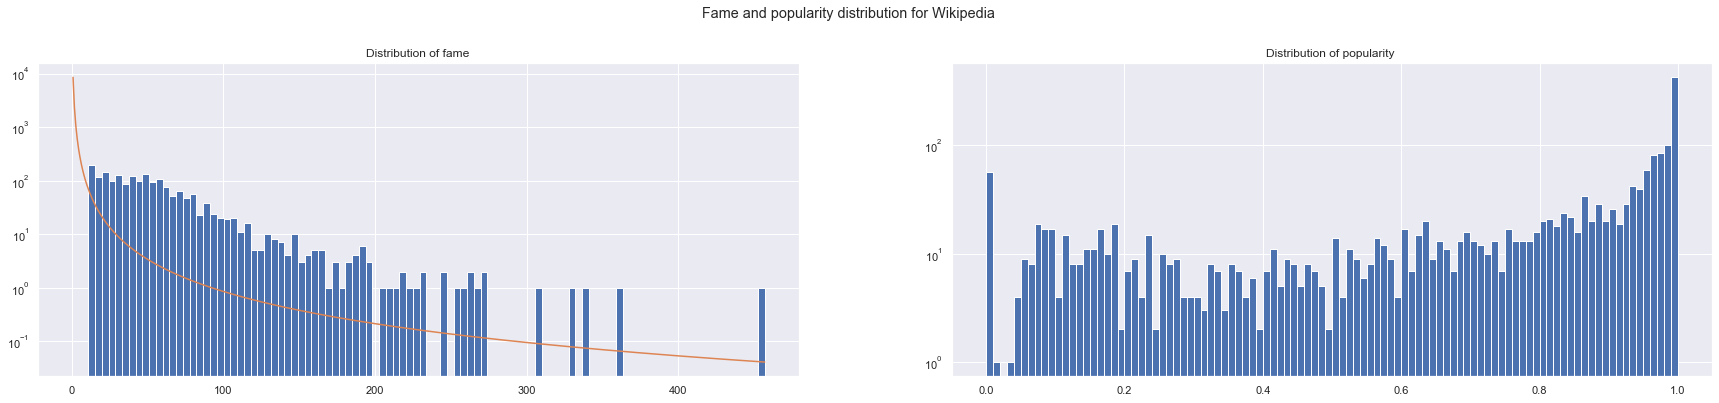

In [9]:
for dataset in datasets:
    #Plot with outliers, power param a=1
    plot_power_law(dataset, "fame_pop", 1)
    #Compute df without ouliers
    dataset['fame_pop_clean'] = dataset['fame_pop'][dataset['fame_pop']['fame'] > 10]
    #Plot with outliers, power param a=1
    plot_power_law(wikipedia, "fame_pop_clean", 1)



Now we are interesting to represent the fame versus the popularity

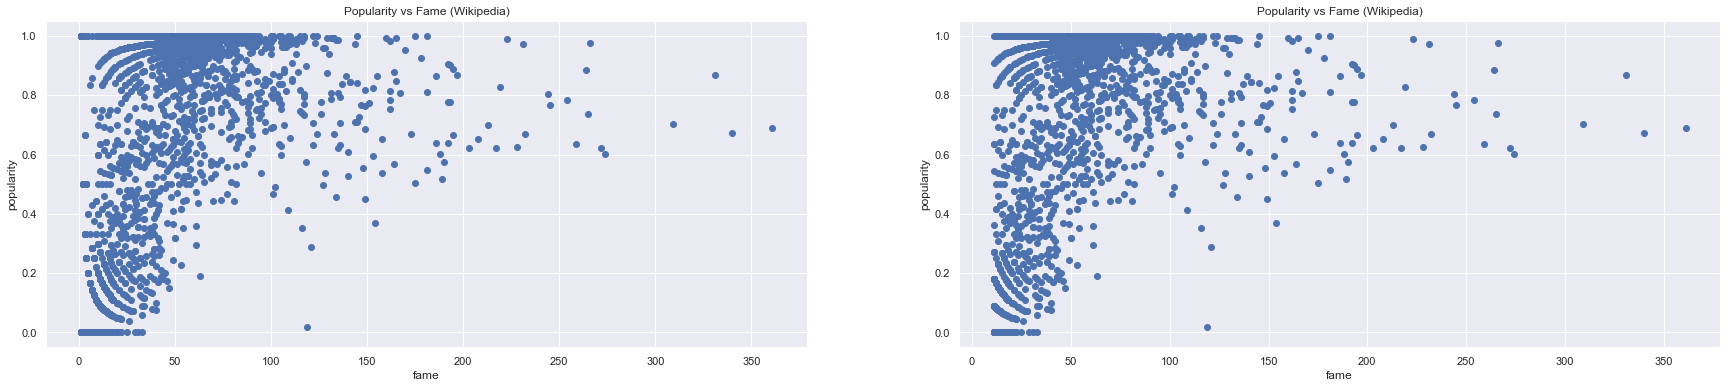

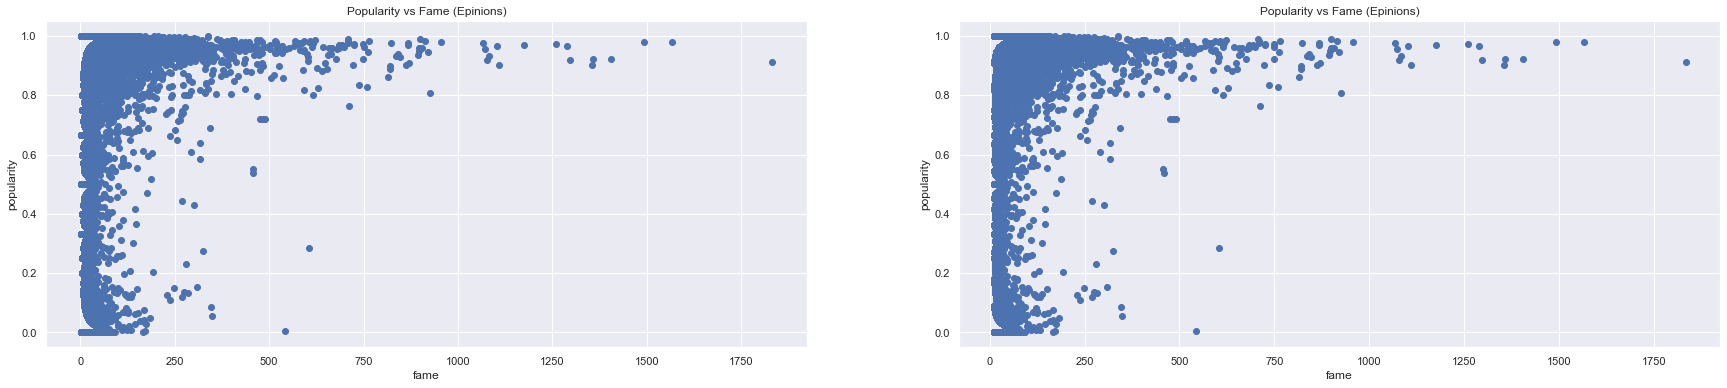

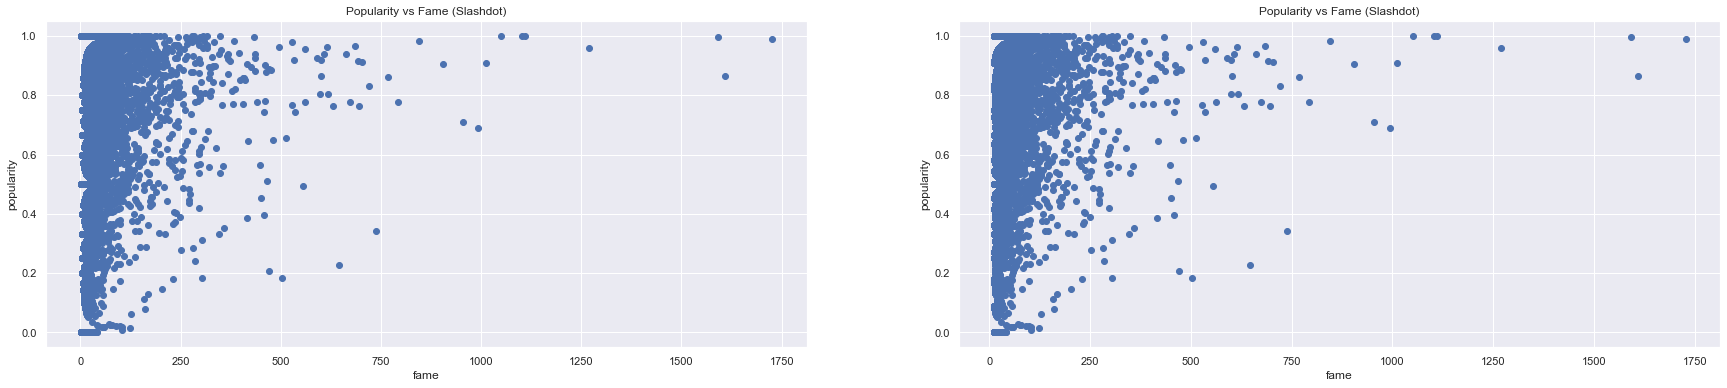

In [10]:
def plot_fame_vs_pop(dataset, df_name, ax):
    fame_pop = dataset[df_name]
    fame_pop = fame_pop[(fame_pop.fame < fame_pop.fame.max()*0.8)]
    ax.set_title("Popularity vs Fame ({})".format(dataset['name']))
    ax.scatter(fame_pop.fame, fame_pop.popularity)
    ax.set_xlabel('fame')
    ax.set_ylabel('popularity')
    
for dataset in datasets:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,6))
    plot_fame_vs_pop(dataset, "fame_pop", ax1)
    plot_fame_vs_pop(dataset, "fame_pop_clean", ax2)
    plt.show()


**Note:**
Since the `fame`correspond to the number of inner edges a user get (neg & pos). It seems interesting to see whether the popularity is dependent of the total number of edges. These clearly a trend: 

- `Slashdot`and `Epinions`: people more positively famous are those who get higher number of votes
- `Wikipedia`: people are more linearly represented in popularity as mentioned before

# Time analysis

The second part of our analysis try to figure out how this new features evoluate over the the time. A data that was not used by the original paper. However for this task we can only focus on the `Wikipedia` and `Epinions` datasets where the time of the vote was saved. 

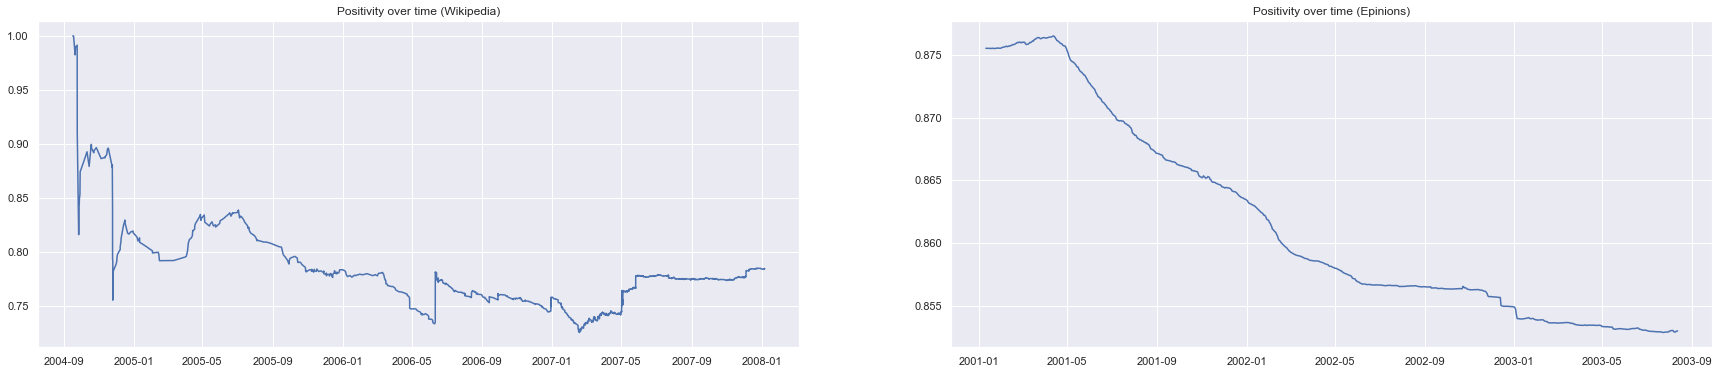

In [11]:
def positivity_over_time(df):
    df = df.copy()
    df['-1'] = (df['Sign'] == -1).astype(int)
    df['+1'] = (df['Sign'] == +1).astype(int)
    df = df[['Date', '-1', '+1']]
    df = df.groupby('Date').sum().sort_values(by='Date').copy()
    df['cumulative_+1'] = None
    df['cumulative_-1'] = None
    sum_p = 0; sum_n = 0
    for index, row in df.iterrows():
        sum_p += row['+1']
        sum_n += row['-1']

        df.at[index, 'cumulative_+1'] = sum_p
        df.at[index, 'cumulative_-1'] = sum_n
    df['positivity'] = df['cumulative_+1'] / (df['cumulative_+1'] + df['cumulative_-1'])
    return df

fig, ax = plt.subplots(1, 2, figsize = (30,6))
for idx, dataset in enumerate(dated_datasets):
    ax[idx].plot(positivity_over_time(dataset['df'])['positivity'])
    ax[idx].set_title(f'Positivity over time ({dataset["name"]})')
    
plt.show()

**Note:**  
- `wikipedia` popularity over time is chaotique without trends with an average of about 78% popularity
- `Epinions` popularity is very high during the first 5 months then decrease progressively until 85.8%

Firstly not that this popularity is less relevant at the begining since we have low number of votes, this can explain the really high value of popularity in the begining for both datasets.  

`Epinions` popularity still decrease afterall then we can deduce that in average the popularity tend to reduce. In general the popularity over time is very high and stay close to 1. Meaning in average most of user are positively popular.

`Wikipedia`do not give us relevant information. One could say that votes happen in a particular time period when a user propose a colleagu for election. This can propose singularity point for votes.

**TO DO**:  
- maybe analyse the arrival of new user along time (they makes popularity higher as expected)

## Fame and popularity distribution over time

<IPython.core.display.Javascript object>


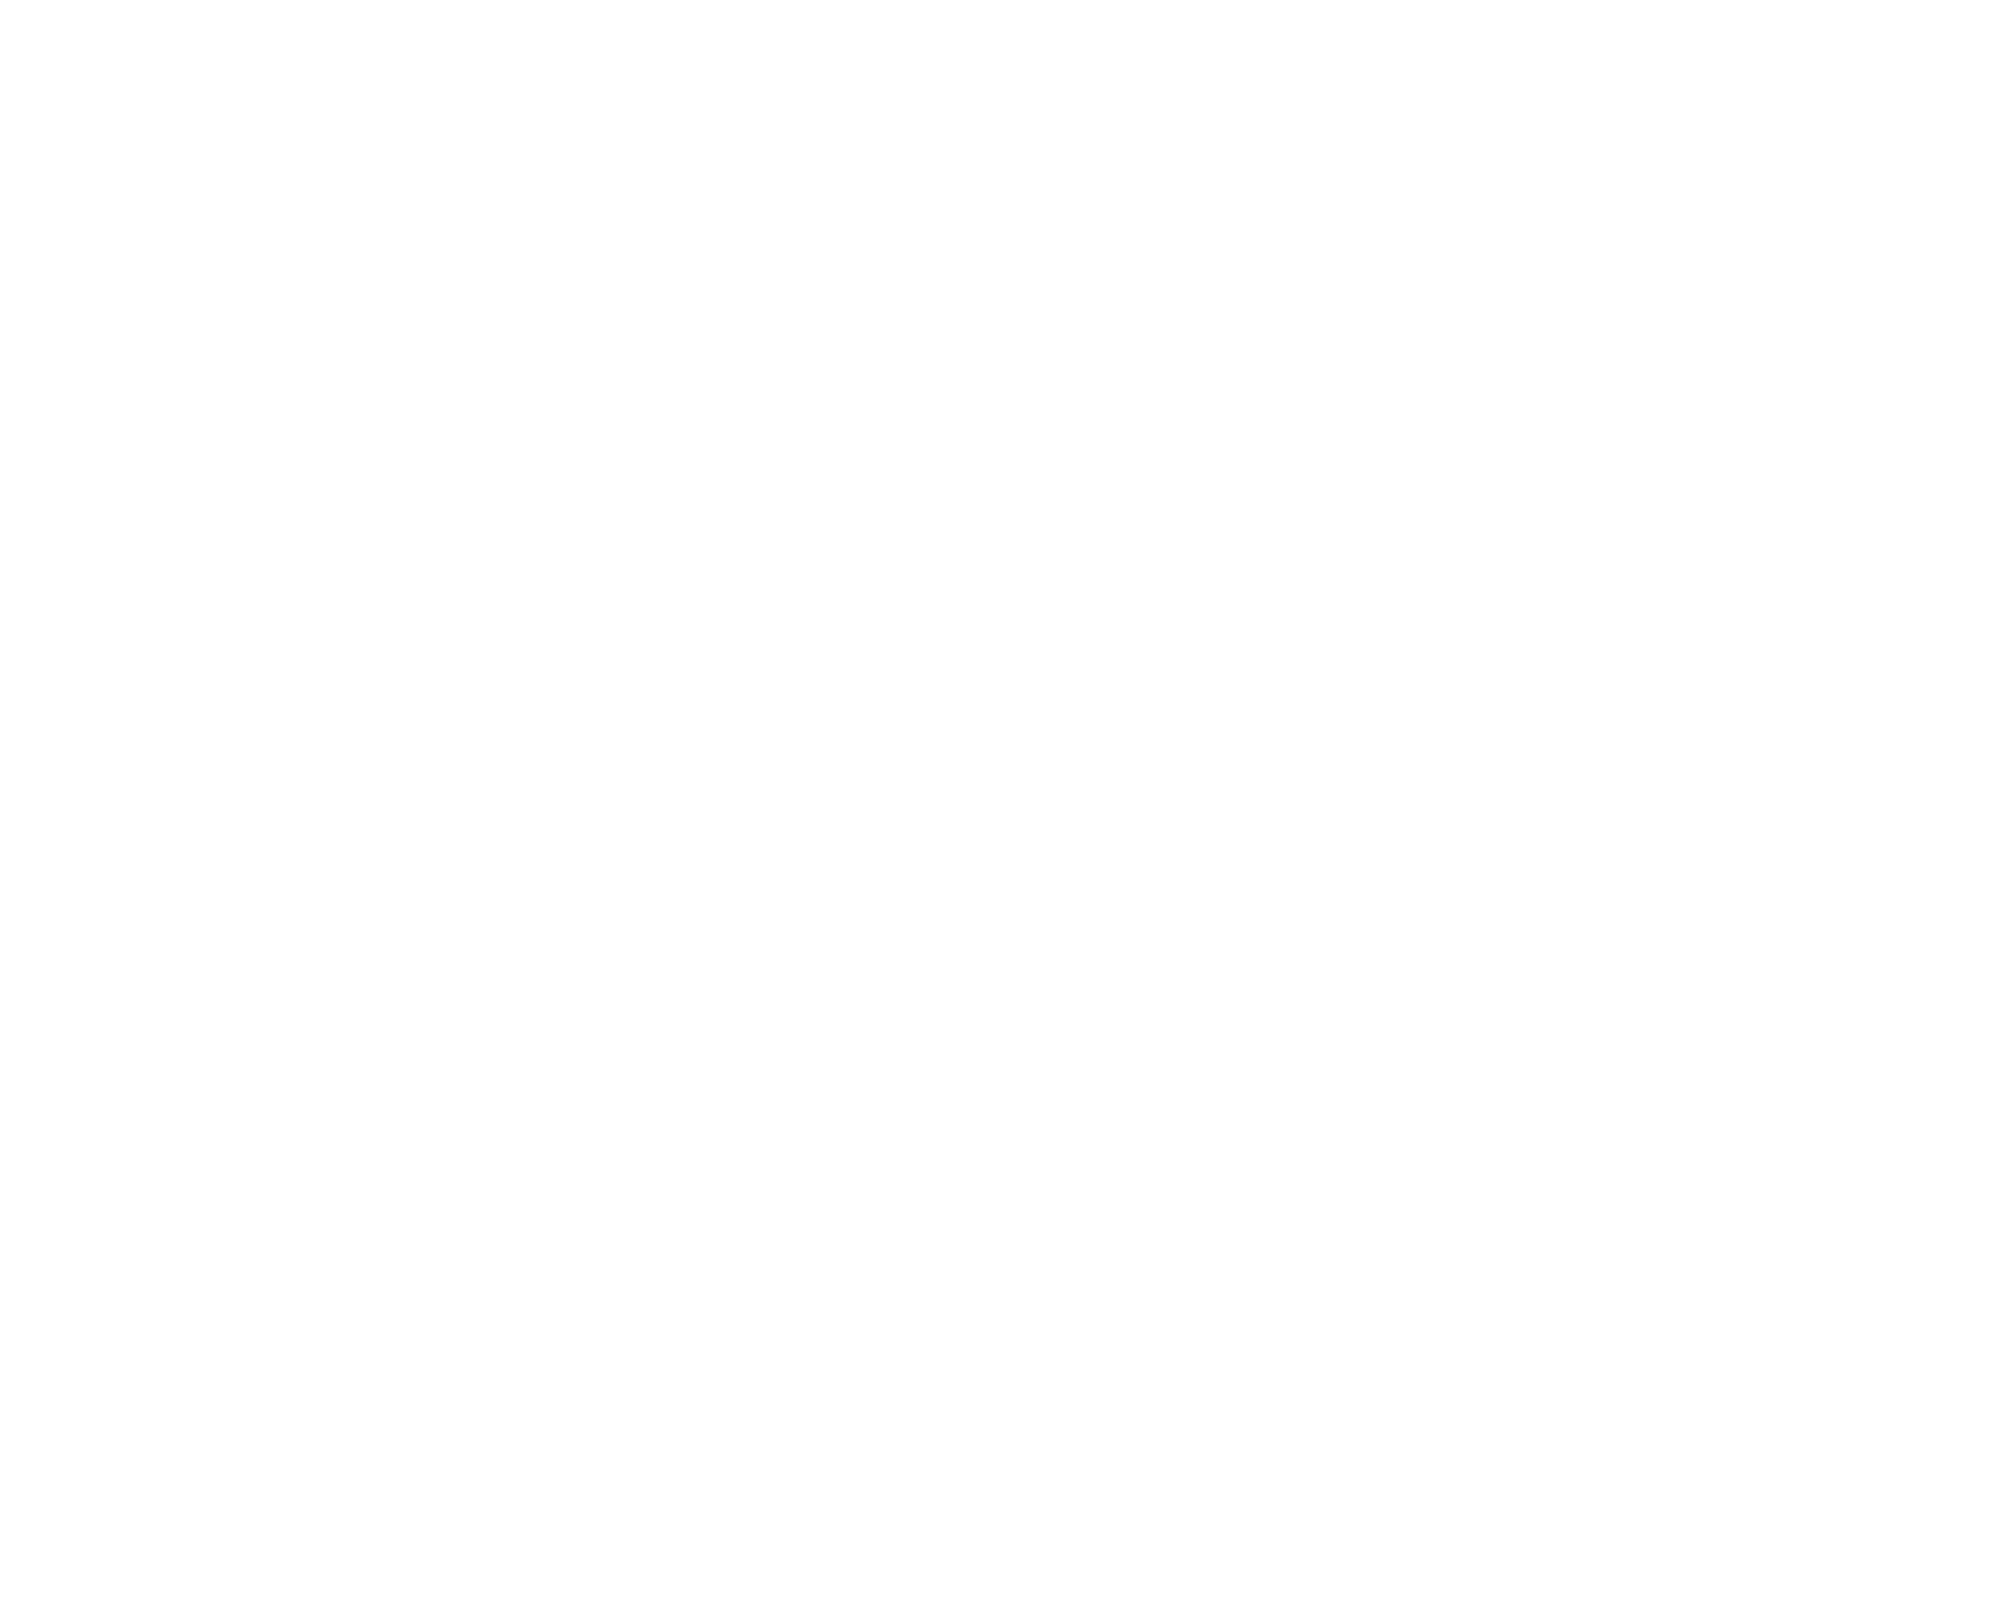

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 1206), layout=Layout(width='500px'),…

<IPython.core.display.Javascript object>


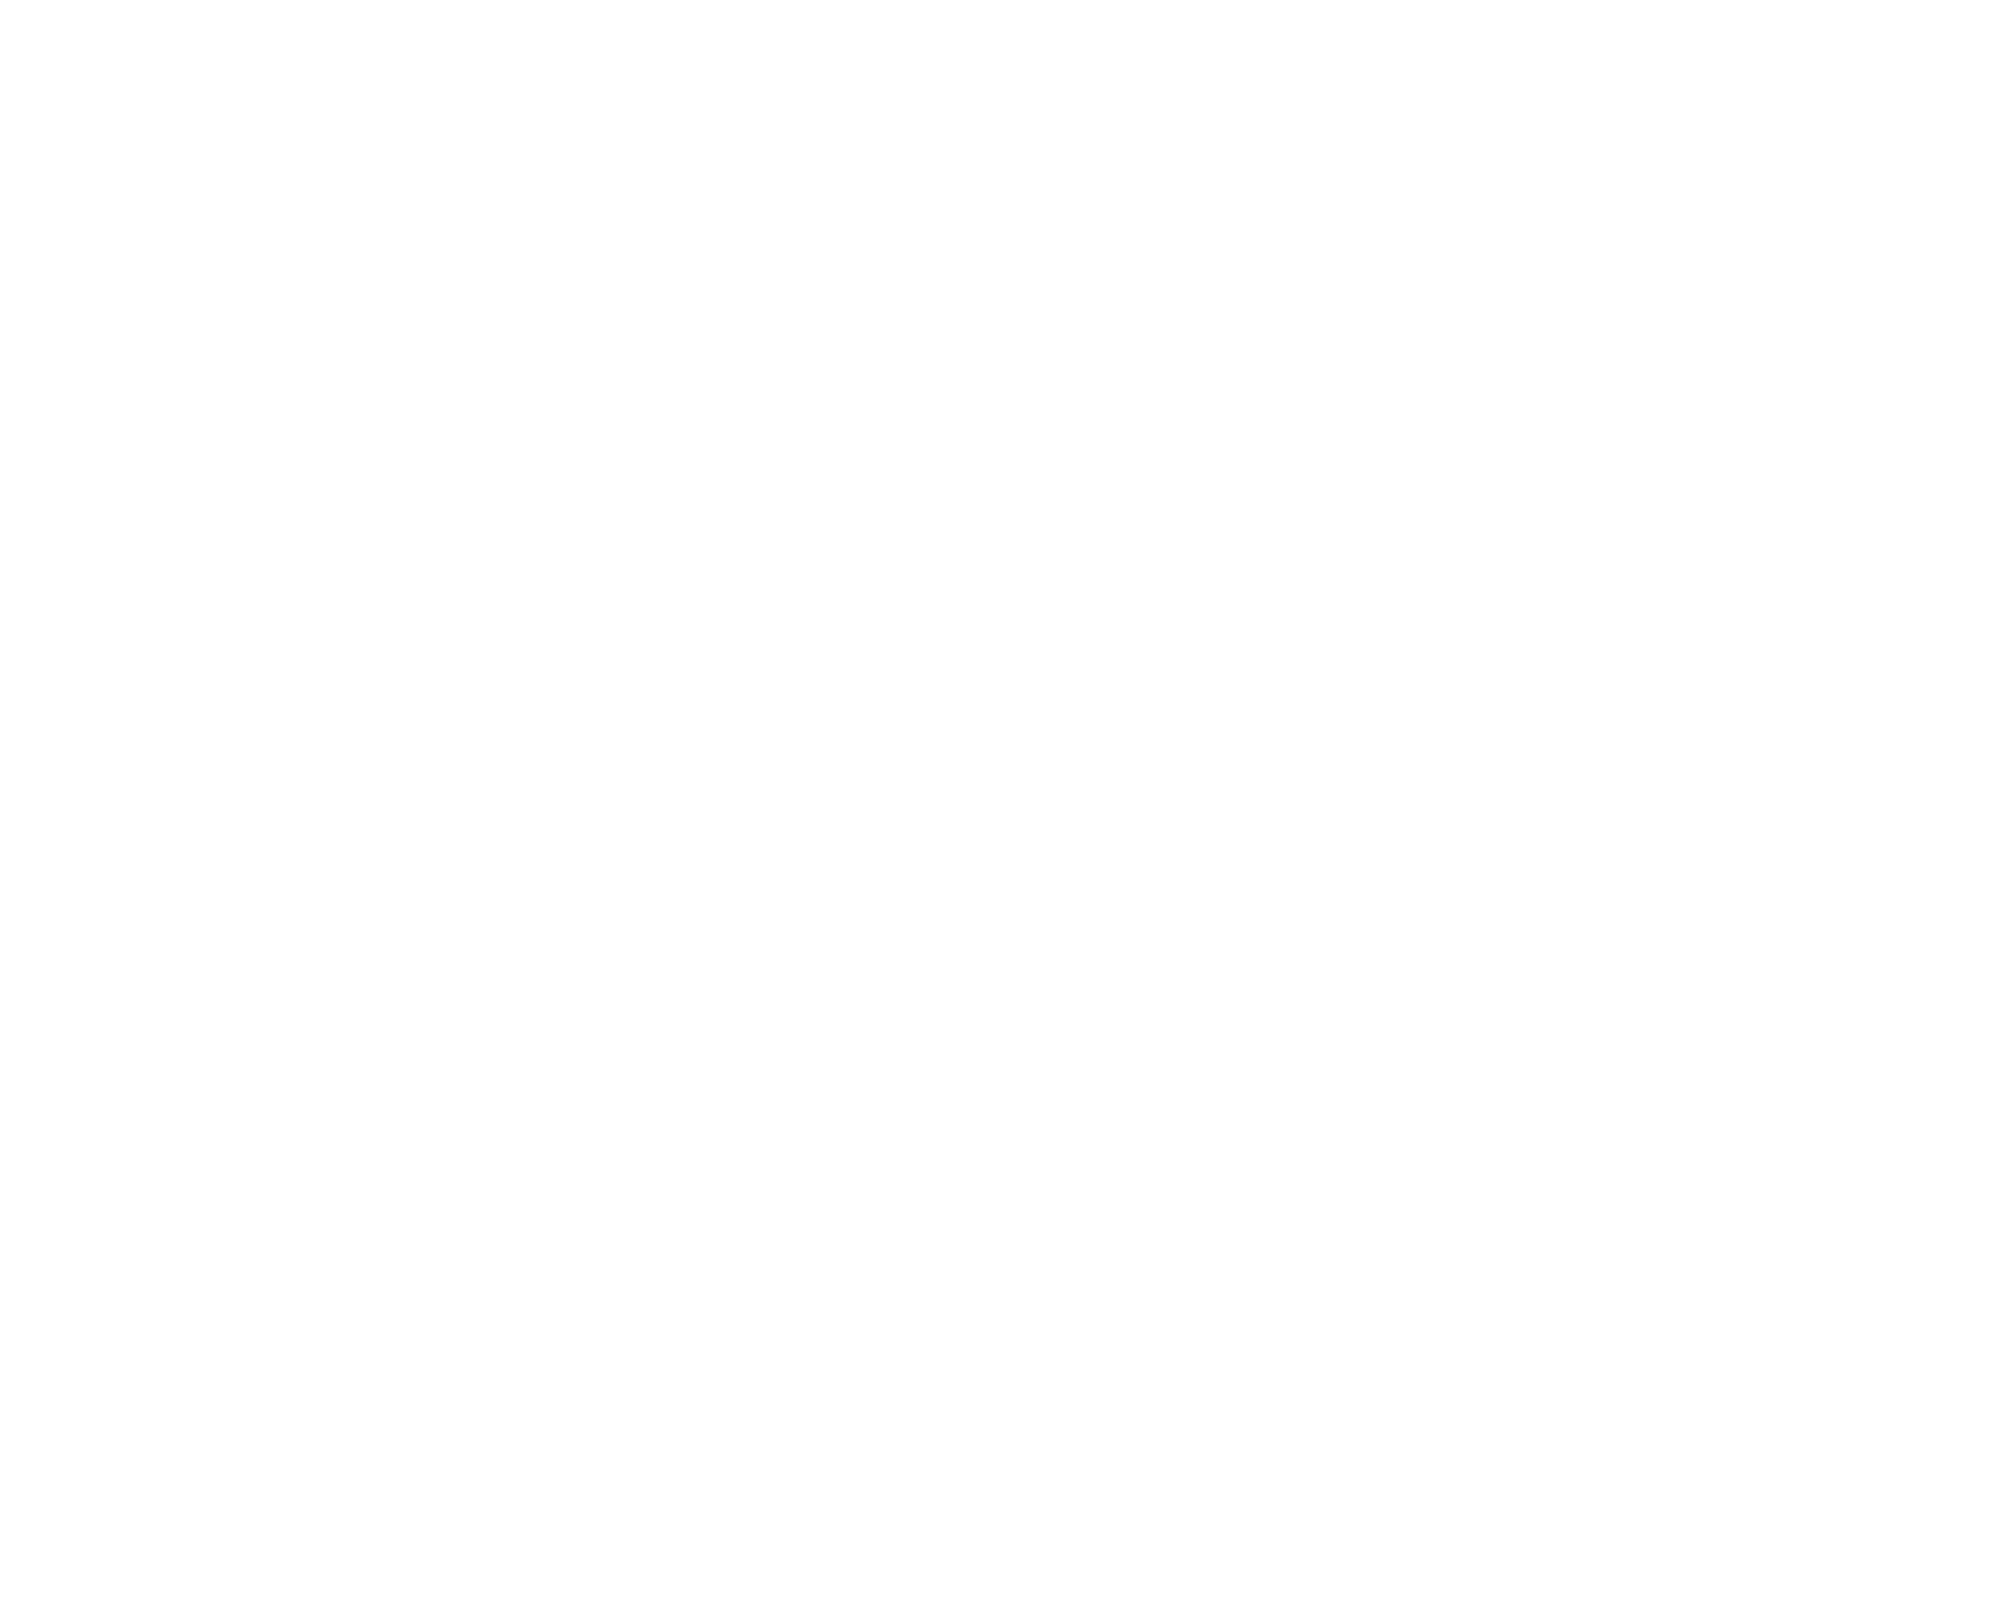

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 944), layout=Layout(width='500px'), …

In [12]:
%matplotlib notebook
from ipywidgets import *

def distribution_over_time(dataset):
    df = dataset['df']

    dates = pd.date_range(df.Date.min(), df.Date.max(), freq='D')
    

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
    fig.suptitle(f'Fame and popularity distribution over time for {dataset["name"]}')
    
    def update(dates):
        new_data = fame_and_popularity(df[(df.Date > dates[0]) & (df.Date < dates[1])])
        ax1.cla()
        ax1.set_title("Distribution of fame ")
        ax1.hist(data=new_data, x='fame', bins=100)
        ax1.set_yscale('log')
        ax2.cla()
        ax2.hist(data=new_data, x='popularity', bins=100)
        ax2.set_title("Distribution of popularity ")
        ax2.set_yscale('log')
        plt.draw()
        
    options = [(date.strftime(' %d %b %Y '), date) for date in dates]
    index = (0, len(options)-1)

    selection_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    interact(update, dates=selection_range_slider);

for d in dated_datasets:
    distribution_over_time(d)

**Note:**  


## Evolution of the most famous/popular users

Now we focus on most famous user. We select the first k users with higher `fame` and `popularity` value along time.

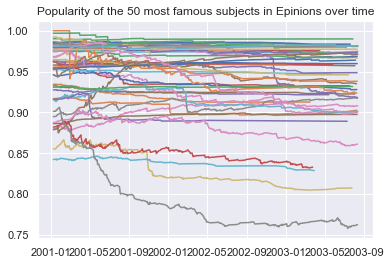

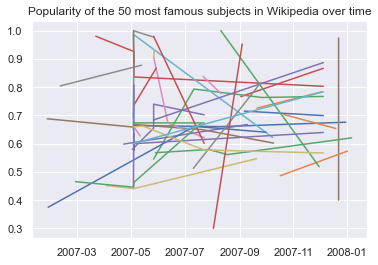

In [13]:
%matplotlib inline
def top_k_evolution(dataset, k=50, start_date=pd.to_datetime('1970')):
    fame = dataset['fame_pop']
    most_famous = fame.nlargest(k, 'fame')
    df = dataset['df']
    plt.figure()
    for nodeId in most_famous.index:
        filtered = df[df.ToNodeId == nodeId]
        pos = positivity_over_time(filtered)
        pos = pos[pos.index > start_date]
        plt.plot(pos['positivity'])
    plt.title(f'Popularity of the {k} most famous subjects in {dataset["name"]} over time')
    plt.show()
    # TODO: plot par rapport au fame, voir par rapport a la moyenne
top_k_evolution(epinions)
top_k_evolution(wikipedia, start_date=pd.to_datetime('2007'))

**Note:**
Si tu prends les top du débutce sont ceux qui n'ont que 1 votes positifs et si ca se trouve il n'evolue pas avec le temps. Il faut revoir comment on plot comme il faut cette evolution...


# Part 2: Haters and Lovers

This second part focus on outer edges. How users interact with other users ?

For our analysis, we are interested by particular behaviours. We define two class of people that produce particular sentimental extreme votes.  

- `activity`: the total review a user performed
- `hater/lover`: the proportion ratio of positive outer links a user send over the total outer edges

A `hater/lover` ratio close to 1 means the user is most likely a "hater", otherwise if the ratio is close 0 the user is most likely a "lover".

In [14]:
## Distrbution of the repartition of the signs from a user
def source_aggregate(dataset):
    df = dataset['df']
    df = df.groupby(['FromNodeId', 'Sign']).count()#.reset_index()
    df = pd.pivot_table(df, index='FromNodeId', values='ToNodeId', columns=['Sign'], fill_value=0)
    df.columns.name = None
    df['activity'] = df[-1] + df[1]
    df['hater'] = df[-1] / df['activity']
    dataset['source'] = df
    return df
    
for d in datasets:
    source_aggregate(d)
    

The first thing to do is to analyse the distribution of `activity`and `hater/lover` avec the 3 datasets.

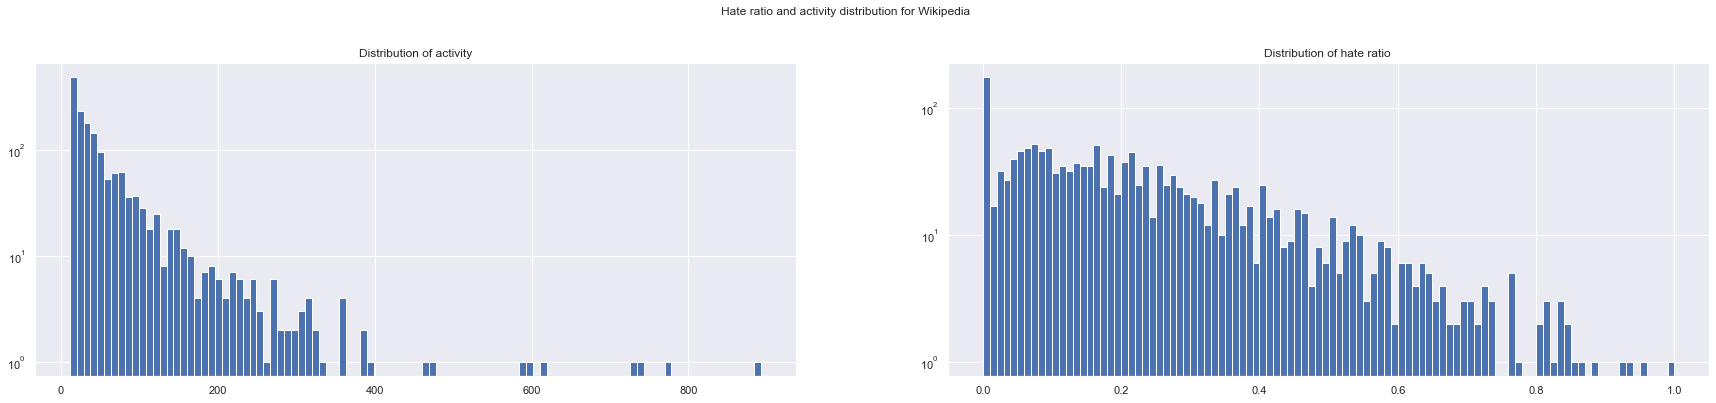

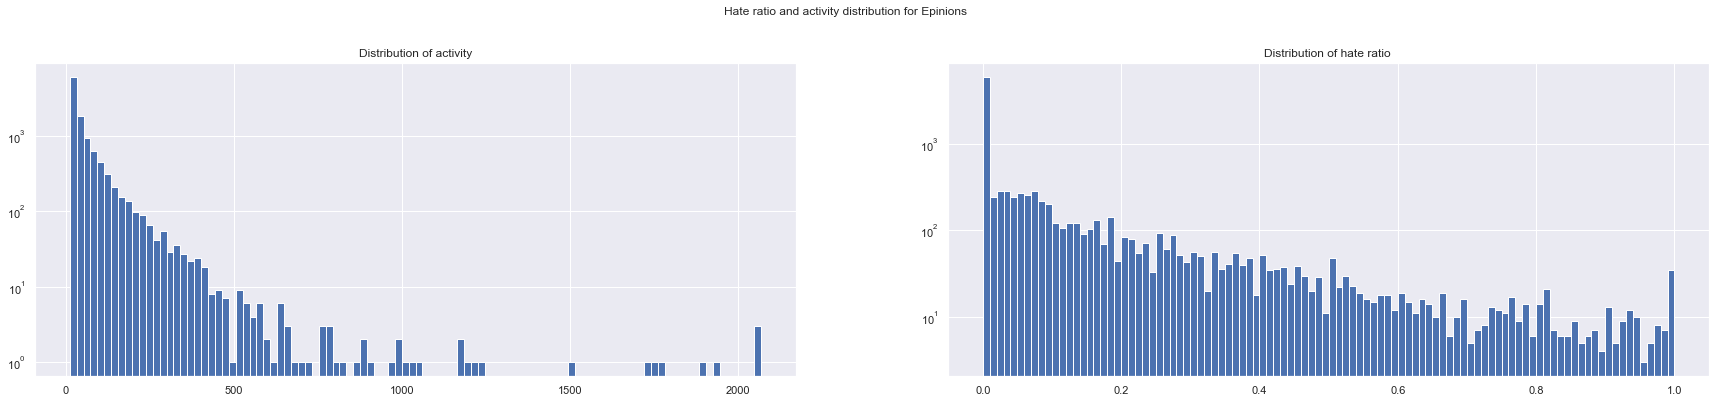

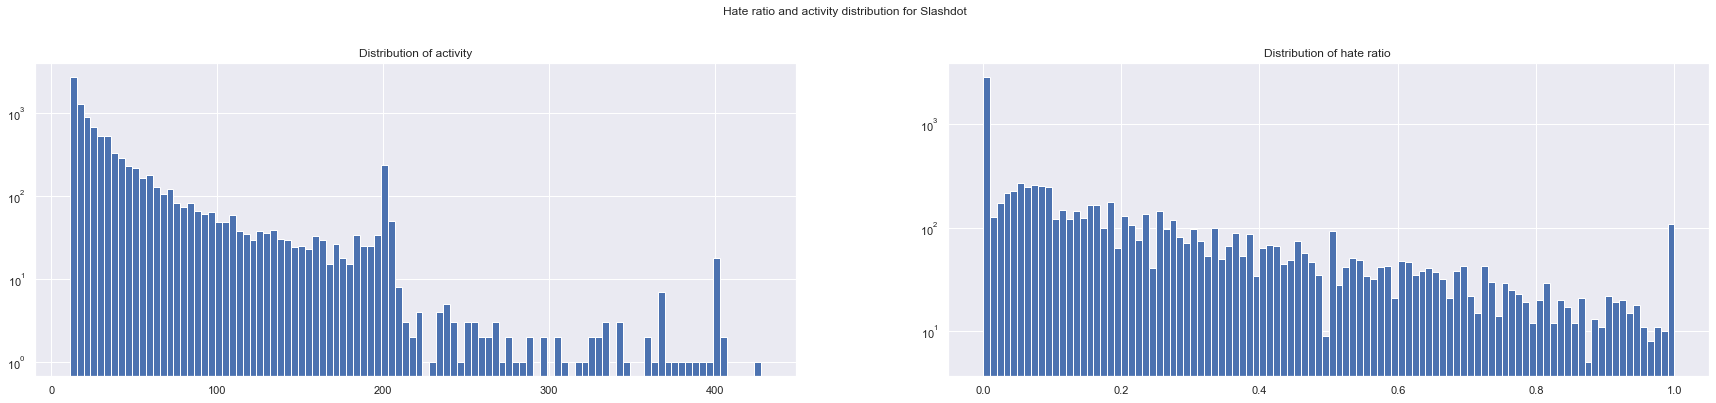

In [15]:
def plot_haters(dataset):
    haters = dataset['source']
    haters = haters[(haters.activity > 10)]# & (haters.hater != 0)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,6))
    fig.suptitle(f'Hate ratio and activity distribution for {dataset["name"]}')

    

    ax1.hist(data=haters, x='activity', bins=100)
    ax1.set_title("Distribution of activity")
    ax1.set_yscale('log')
    
    ax2.hist(data=haters, x='hater', bins=100)
    ax2.set_title("Distribution of hate ratio ")
    ax2.set_yscale('log')


    plt.subplots_adjust(top = 0.85, hspace=0.5)
    plt.show()

for d in datasets:
    plot_haters(d)

**Note:**  
- `Wikipedia` and `Epinions`: `activity` distribution seems to follow a power low distribution 
- `Slashdot`: `activity` distribution seems to follow a power low distribution with an anomalie around 200

Compare to the `fame`there is not a big different between the 3 datasets concerning the user votes behaviour. This can explains that the behaviour is constant indepently to the aim of the media. The anamolie around 200 should be explain for slashdot.  
=> **social behaviour**

- For each dataset, there are a lots of 1 values for `activity`

Thus is the similar phenomenon that happen for `frame`. This correspond to user that produce only one vote. These users less interact with other users and elections, there are poor observators and we could imagine that there is a proportion of them that belongs to those less "observed" (low `frame`) in the first part.

- `Slashdot` and `Epinions`: `hater/lover` distribution show there is a linear evolution over number of lovers and haters downwardings
- `Wikipedia`: `hater/lover` distribution show a concentration of lovers and few people as haters or strongly haters.
- Many 0 and 1 values for `Slashdot` and `Epinions` dataset  

The user with 0 and 1 `hater ratio` is most likely people which send low number of votes (low activity) with `hater ratio` of 0 of it send a positive link and a `hater ratio` of 1 if the it send negative link. The linear distribution in `Slashdot` and `Epinions` suggest people are mostly lovers than haters with, the low slope suggest a low difference in proportion. But globaly people votes positively. For `Wikipedia` there are a strong concentration for lovers people. This difference can be explain by the aim of the medias, same argument as before.

**Note**
- Classify 4 classes: (low fame, low activity) (low fame, high activity) , (high fame, low activity) (high fame, high activity)
- Separate low number of votes user to extract real haters and lovers

## Classification next sign

**Effect of popularity over appreciation:** figure out whether popularity can influence statistically the appreciation of other nodes. Specifically, determine the influence of haters/lovers combining with their popularity using a clasification method.



In [16]:
%%time
# Features for each link: popularity and fame of source and destination, at the time the link was made

# Compute the cumulative count up to each date
def cumulative(df, sign, nodeId_attribute):
    df['count'] = (df['Sign'] == sign).astype(int)
    df_out = df[[nodeId_attribute, 'Date', 'count']].groupby([nodeId_attribute, 'Date']).sum()
    df_out = df_out.unstack(fill_value=0)
    # At this point, we have one row per NodeId, and one columns per date: 
    # the number of link at this date with for this NodeId with the given sign
    # We will fold on the columns, to have the aggregated values
    columns = list(df_out.columns)
    assert sorted(columns) == columns
    for date in range(1, len(columns)):
        df_out[columns[date]] += df_out[columns[date - 1]]
    df.drop(columns=['count'])
    return df_out

# Compute the popularity, fame, total_reviews, hate_score of the nodes for each link
def nodeId_stats(df):
    df = df.copy().reset_index()

    # Popularity and fame
    pos = cumulative(df, +1, 'ToNodeId')
    neg = cumulative(df, -1, 'ToNodeId')
    assert list(pos.columns) == list(neg.columns)
    
    # Compute fame and popularty, in long format to be able to join
    fame = (pos + neg)
    popularity = (pos / fame).rename(columns={'count': 'popularity'})
    fame = fame.rename(columns={'count': 'fame'})
    stats = popularity.merge(fame, left_index=True, right_index=True)

    # hate_score and total_reviews
    pos = cumulative(df, +1, 'FromNodeId')
    neg = cumulative(df, -1, 'FromNodeId')
    total_reviews = (pos + neg)
    hate_score = (neg / total_reviews).rename(columns={'count': 'hate_score'})
    total_reviews = total_reviews.rename(columns={'count': 'activity'})
    stats2 = hate_score.merge(total_reviews, left_index=True, right_index=True)

    stats = stats.merge(stats2, left_index=True, right_index=True, how='outer').stack()

    
    # Add all the stats to the dataset
    for nodeId_attribute in ['FromNodeId', 'ToNodeId']:
        df = %time df.set_index([nodeId_attribute, 'Date']).sort_index()
        df = df.join(stats.add_prefix(nodeId_attribute + '_'), on=[nodeId_attribute, 'Date'])
        df = df.reset_index()
    return df

def regression_df(dataset):
    df = dataset['df'].copy()
    df = nodeId_stats(df)
    return df


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [17]:
wiki = regression_df(wikipedia)
display(wiki.info())
display(wiki.head())

CPU times: user 30.3 ms, sys: 20.9 ms, total: 51.3 ms
Wall time: 51.4 ms
CPU times: user 17.3 ms, sys: 3.08 ms, total: 20.4 ms
Wall time: 20.5 ms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103747 entries, 0 to 103746
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ToNodeId               103747 non-null  int64         
 1   Date                   103747 non-null  datetime64[ns]
 2   FromNodeId             103747 non-null  int64         
 3   index                  103747 non-null  int64         
 4   Sign                   103747 non-null  int64         
 5   count                  103747 non-null  int64         
 6   FromNodeId_activity    103747 non-null  float64       
 7   FromNodeId_fame        57992 non-null   float64       
 8   FromNodeId_hate_score  103747 non-null  float64       
 9   FromNodeId_popularity  35185 non-null   float64       
 10  ToNodeId_activity 

None

,ToNodeId,Date,FromNodeId,index,Sign,count,FromNodeId_activity,FromNodeId_fame,FromNodeId_hate_score,FromNodeId_popularity,ToNodeId_activity,ToNodeId_fame,ToNodeId_hate_score,ToNodeId_popularity
0,3,2006-12-29 16:13:12,6,1100,1,0,124.0,20.0,0.161290,0.950000,20.0,31.0,0.0,0.903226
1,3,2006-12-29 16:13:12,10,1095,1,0,54.0,15.0,0.166667,0.600000,20.0,31.0,0.0,0.903226
2,3,2006-12-29 16:13:12,14,1121,1,0,62.0,NaN,0.193548,NaN,20.0,31.0,0.0,0.903226
3,3,2006-12-29 16:13:12,17,1105,1,0,28.0,NaN,0.107143,NaN,20.0,31.0,0.0,0.903226
4,3,2006-12-29 16:13:12,19,1115,1,0,37.0,22.0,0.000000,0.863636,20.0,31.0,0.0,0.903226


In [18]:
wiki = wiki.fillna(0.)
display(wiki.head())
wiki = wiki.drop(['Date', 'index', 'count'], axis=1)
display(wiki.head())


,ToNodeId,Date,FromNodeId,index,Sign,count,FromNodeId_activity,FromNodeId_fame,FromNodeId_hate_score,FromNodeId_popularity,ToNodeId_activity,ToNodeId_fame,ToNodeId_hate_score,ToNodeId_popularity
0,3,2006-12-29 16:13:12,6,1100,1,0,124.0,20.0,0.161290,0.950000,20.0,31.0,0.0,0.903226
1,3,2006-12-29 16:13:12,10,1095,1,0,54.0,15.0,0.166667,0.600000,20.0,31.0,0.0,0.903226
2,3,2006-12-29 16:13:12,14,1121,1,0,62.0,0.0,0.193548,0.000000,20.0,31.0,0.0,0.903226
3,3,2006-12-29 16:13:12,17,1105,1,0,28.0,0.0,0.107143,0.000000,20.0,31.0,0.0,0.903226
4,3,2006-12-29 16:13:12,19,1115,1,0,37.0,22.0,0.000000,0.863636,20.0,31.0,0.0,0.903226


,ToNodeId,FromNodeId,Sign,FromNodeId_activity,FromNodeId_fame,FromNodeId_hate_score,FromNodeId_popularity,ToNodeId_activity,ToNodeId_fame,ToNodeId_hate_score,ToNodeId_popularity
0,3,6,1,124.0,20.0,0.161290,0.950000,20.0,31.0,0.0,0.903226
1,3,10,1,54.0,15.0,0.166667,0.600000,20.0,31.0,0.0,0.903226
2,3,14,1,62.0,0.0,0.193548,0.000000,20.0,31.0,0.0,0.903226
3,3,17,1,28.0,0.0,0.107143,0.000000,20.0,31.0,0.0,0.903226
4,3,19,1,37.0,22.0,0.000000,0.863636,20.0,31.0,0.0,0.903226


**Pipeline:**

Working on both `Wikipedia` and `Epinions` datasets:  

* **Split training and testing set:** we will split our data in a random proportion of 80% for training and 20% 


* **Normalization:** `popularity` and `hater_score` are already normalized, 

* **Features selection**: the features choose for regression are: `popularity`, `frame`, `activity` and `hater_score`.

* **Regression**: Logistic Regression adn Gradient Boosting Classifier are used for classification. GBC will be use for this study. This model performs extremely well for a variety of tasks and is often used in machine learning competitions. Indeed it trains many decision trees in a gradual, additive, and sequential manner where subsequent models correct the performance of prior models. It is a kind of bootstrap aggregation of different models in a tree format working similarly to the Adaboost optimizer. 


Maybe supress the first 5months to avoid weird values correspond to the begining of the website or voting procedure.


In [19]:
#Split training and testing set
def longitudinal_split(data, proportion=0.7):
    train_set = data.head(int(np.ceil(len(data)*proportion)))
    test_set = data.tail(int(np.floor(len(data)*(1. - proportion))))
    assert len(data) == len(train_set) + len(test_set)
    return train_set, test_set

# Split the data randomly
def random_split(data, ratio=0.7):
    mask = np.random.rand(len(data)) < ratio
    return data[mask].reset_index(drop=True), data[~mask].reset_index(drop=True)

#Normalization by min max scaler
def normalize(X_train, X_test, columns):
    #Min and Max from training set
    min_scale = X_train.min()
    max_scale = X_train.max()
    
    #Normalize training set
    X_train_norm = pd.DataFrame()
    for c in columns:
        X_train_norm[c] = (X_train[c] - min_scale[c])/(max_scale[c] - min_scale[c])

    #Normalize test set
    X_test_norm = pd.DataFrame()
    for c in columns:
        X_test_norm[c] = (X_test[c] - min_scale[c])/(max_scale[c] - min_scale[c])
    
    return X_train_norm, X_test_norm

#Normalization by standardization Norm
def standardize(X_train, X_test, columns):
    #Means and stardard deviation from training set
    means = X_train.mean()
    stddevs = X_train.std()
    
    #Standardize training set
    X_train_std = pd.DataFrame()
    for c in columns:
        X_train_std[c] = (X_train[c]-means[c])/stddevs[c]

    # Standardize test set
    X_test_std = pd.DataFrame()
    for c in columns:
        X_test_std[c] = (X_test[c]-means[c])/stddevs[c]
    
    return X_train_std, X_test_std

from random import shuffle

# Split a dataset into k folds
def cross_validation_split(data, folds):
    # Shuffles the indices of the dataset
    data_copy = np.copy(data)
    fold_size = int(len(data) / folds)
    indices = data.index.to_list()
    shuffle(indices)
    # Slice the shuffled indices
    return [indices[fold_size * i: fold_size * (i + 1)] for i in range(folds)]

In [28]:
# Create GBR model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

def run_model(name, estimator, train_set, test_set, features, target, norm_columns=None):
    if norm_columns is None:
        norm_columns = features
    # Select input / output for training set
    X_train = train_set[features]
    y_train = train_set[target]
    
    # Select input /output for test set
    X_test = test_set[features]
    y_test = test_set[target]
    
    # Normalize
    X_train[norm_columns], X_test[norm_columns] = normalize(X_train, X_test, norm_columns)

    
    
    #Selector features
    selector = SelectFromModel(estimator).fit(X_train, y_train)
    # Compute the accuracy of the model
    print("The accuracy for {} test set is: {:.03}".format(name, selector.estimator_.score(X_test, y_test)))
    print("\nThe threshold value used for feature selection: ", selector.threshold_)
    print("Corresponding mask selection: ", selector.get_support()) #Get a mask, or integer index, of the features selected
    
    model = selector.estimator_
    return X_test, y_test, model


In [29]:
features = ['FromNodeId_popularity', 'ToNodeId_popularity', 'ToNodeId_fame', 'FromNodeId_fame']#, 'ToNodeId','FromNodeId']
norm_col = ['ToNodeId_fame', 'FromNodeId_fame']

target = 'Sign'
train_set, test_set = random_split(wiki)

print("\n===== Gradient Boosting classifier =====")
_, _, model_GBC = run_model("GBC",GradientBoostingClassifier(), train_set, test_set, features, target, norm_col)
print("Features importance:", model_GBC.feature_importances_)

print("\n===== Logistique Regression =====")
_, _, model_log = run_model("Logistique Regression",LogisticRegression(), train_set, test_set, features, target, norm_col)
print("Coefficients and intercept:", model_log.coef_, model_log.intercept_)






===== Gradient Boosting classifier =====


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


The accuracy for GBC test set is: 0.862

The threshold value used for feature selection:  0.24999999999999997
Corresponding mask selection:  [False  True False False]
Features importance: [0.00931741 0.97595991 0.00274804 0.01197464]

===== Logistique Regression =====
The accuracy for Logistique Regression test set is: 0.86

The threshold value used for feature selection:  1.9920777492911594
Corresponding mask selection:  [False  True False False]
Coefficients and intercept: [[-0.05370506  6.68755153 -0.90928152  0.31777289]] [-3.24931571]


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Note (`popularity model`):**  
When trying to determine the sign of the edge from the `popularity` and the `fame` point of views which reach quite good approximation.  

The most important features is here: `ToNodeId_popularity`. Which mean the `popularity` of those who receive the vote is strongly correlated with the result of the sign. Note that the `fame`of this node is not sufficient to anticipate the vote and the `fame`and `popularity` of the voter do not affect the vote consequently.

In [30]:
features = ['FromNodeId_hate_score', 'ToNodeId_hate_score', 'ToNodeId_activity', 'FromNodeId_activity']#, 'ToNodeId','FromNodeId']
norm_col = ['ToNodeId_activity', 'FromNodeId_activity']
target = 'Sign'
train_set, test_set = random_split(wiki)

print("\n===== Gradient Boosting classifier =====")
_, _, model_GBC = run_model("GBC",GradientBoostingClassifier(), train_set, test_set, features, target, norm_col)
print("Classes:", model_GBC.classes_)
print("Features importance:", model_GBC.feature_importances_)

print("\n===== Logistique Regression =====")
_, _, model_log = run_model("Logistique Regression",LogisticRegression(), train_set, test_set, features, target, norm_col)
print("Classes:", model_log.classes_)
print("Coefficients and intercept:", model_log.coef_, model_log.intercept_)






===== Gradient Boosting classifier =====


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


The accuracy for GBC test set is: 0.833

The threshold value used for feature selection:  0.25
Corresponding mask selection:  [ True False False False]
Classes: [0 1]
Features importance: [0.9019595  0.01964342 0.07531461 0.00308247]

===== Logistique Regression =====
The accuracy for Logistique Regression test set is: 0.826

The threshold value used for feature selection:  2.113528799577376
Corresponding mask selection:  [ True False False False]
Classes: [0 1]
Coefficients and intercept: [[-5.84070164  0.27486148  2.04134223 -0.29720985]] [2.96855935]


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Note (`hater model`):**  
When trying to regress over `activity`  and `hater_score` point of views we obtain a good approximation but perform worse than the `popularity model`.  

The most important features is here: `FromNodeId_hate_score`. Which means the `hate_score` of those who send the vote is strongly negatively correlated with the result of the sign. Note even if the `activity` of receiver is not keep as important features its coefficient is a bit important


In [23]:
features = ['FromNodeId_popularity', 'ToNodeId_popularity', 'ToNodeId_fame', 'FromNodeId_fame', 'FromNodeId_hate_score', 'ToNodeId_hate_score', 'ToNodeId_activity', 'FromNodeId_activity']#, 'ToNodeId','FromNodeId']
norm_col = ['ToNodeId_fame', 'FromNodeId_fame', 'ToNodeId_activity', 'FromNodeId_activity']

target = 'Sign'
train_set, test_set = random_split(wiki)

print("\n===== Gradient Boosting classifier =====")
_, _, model_GBC = run_model("GBC",GradientBoostingClassifier(), train_set, test_set, features, target, norm_col)
print("Classes:", model_GBC.classes_)
print("Features importance:", model_GBC.feature_importances_)

print("\n===== Logistique Regression =====")
_, _, model_log = run_model("Logistique Regression",LogisticRegression(), train_set, test_set, features, target, norm_col)
print("Classes:", model_log.classes_)
print("Coefficients and intercept:", model_log.coef_, model_log.intercept_)






===== Gradient Boosting classifier =====


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


The accuracy for GBC test set is: 0.904

The threshold value used for feature selection:  0.125
Corresponding mask selection:  [False  True False False  True False False False]
Classes: [-1  1]
Features importance: [1.59127117e-03 6.65905278e-01 1.70643492e-03 5.79064737e-04
 3.27803703e-01 4.50790035e-04 2.26211540e-04 1.73724634e-03]

===== Logistique Regression =====
The accuracy for Logistique Regression test set is: 0.901

The threshold value used for feature selection:  2.1219963241719055
Corresponding mask selection:  [False  True False False  True False False False]
Classes: [-1  1]
Coefficients and intercept: [[-0.4760396   7.06680916 -1.26416912  0.76470177 -6.3431502   0.26342991
  -0.09870939 -0.69896144]] [-1.4012211]


/Users/matthieubaud/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Note (averall model):**  

The model that use all features data. We can enhance the global result of our regression and get an accuracy of about 90%.

As expected the two relevant features are those determine above: `ToNodeId_popularity`, `FromNodeId_hate_score` respectively positively and negatively correlated.

### Statistical analysis 

The regression model fits well the purpose of SIgn estimation. To go further the statiscal analysis, let's analyse the features important using stats model library. To do not completely repeat ourself we choose a different approach to analyse sub-model: the `sender` and `receiver` point of views

In [31]:
def importance_analysis(res):
    # feature names
    variables = res.params.index
    # coefficients
    coefficients = res.params.values
    # p-values
    p_values = res.pvalues
    # standard errors
    standard_errors = res.bse.values
    #confidence intervals
    display(res.conf_int()) 
    #Combine coefficients information
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    #Plot error bars
    plt.title("Errors bar plots for each variable")
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2);
    plt.show()

===== Sender POV =====
Optimization terminated successfully.
         Current function value: 0.389521
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Sign   No. Observations:               103747
Model:                          Logit   Df Residuals:                   103742
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.2528
Time:                        16:32:17   Log-Likelihood:                -40412.
converged:                       True   LL-Null:                       -54083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.1014      0.020    154.205      0.0

,0,1
Intercept,3.062024,3.140863
FromNodeId_fame,-0.000697,0.000514
FromNodeId_popularity,-0.169441,-0.045228
FromNodeId_activity,-0.000290,0.000082
FromNodeId_hate_score,-5.934454,-5.762961


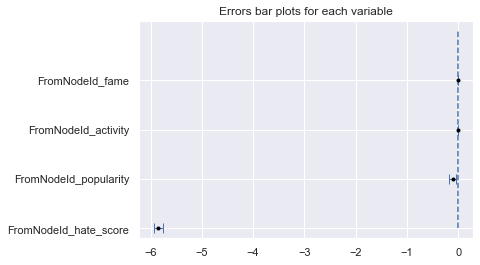

===== Receiver POV =====
Optimization terminated successfully.
         Current function value: 0.321580
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Sign   No. Observations:               103747
Model:                          Logit   Df Residuals:                   103742
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.3831
Time:                        16:32:17   Log-Likelihood:                -33363.
converged:                       True   LL-Null:                       -54083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.2724      0.032   -101.497      0.000  

,0,1
Intercept,-3.335555,-3.209172
ToNodeId_fame,-0.002308,-0.001707
ToNodeId_popularity,6.632178,6.808436
ToNodeId_activity,-0.000662,0.000085
ToNodeId_hate_score,0.047320,0.220721


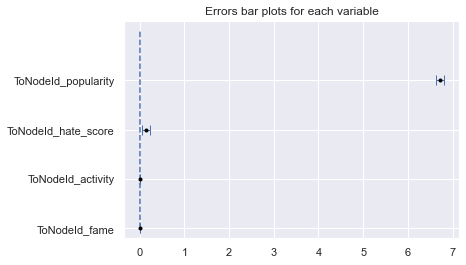

In [33]:
# Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
#Ensure output between [0, 1]
wiki['Sign'] = wiki['Sign'].replace({-1: 0})

# Sender point of view
print("===== Sender POV =====")
# Create the logistique regression model: 
model = smf.logit(formula='Sign ~ FromNodeId_fame + FromNodeId_popularity + FromNodeId_activity + FromNodeId_hate_score ', data=wiki)
# Fit the model
res = model.fit()
print(res.summary())
#Plot importance graph
importance_analysis(res)

# Sender point of view
print("===== Receiver POV =====")
model = smf.logit(formula='Sign ~ ToNodeId_fame + ToNodeId_popularity + ToNodeId_activity + ToNodeId_hate_score', data=wiki)
# Fit the model
res = model.fit()
print(res.summary())
#Plot importance graph
importance_analysis(res)




===== Averall model =====
Optimization terminated successfully.
         Current function value: 0.239383
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Sign   No. Observations:               103747
Model:                          Logit   Df Residuals:                   103738
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.5408
Time:                        16:32:22   Log-Likelihood:                -24835.
converged:                       True   LL-Null:                       -54083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.4240      0.039    -36.371      

,0,1
Intercept,-1.500716,-1.347244
FromNodeId_hate_score,-6.507914,-6.274646
ToNodeId_hate_score,0.177436,0.378515
ToNodeId_activity,-0.000927,-0.000069
FromNodeId_activity,-0.001104,-0.000629
FromNodeId_fame,0.000953,0.002503
ToNodeId_fame,-0.003033,-0.002319
ToNodeId_popularity,7.037201,7.252688
FromNodeId_popularity,-0.531152,-0.370460


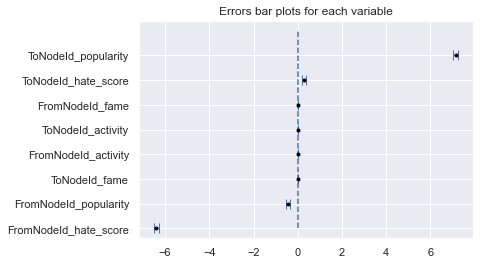

In [34]:
print("===== Averall model =====")
model = smf.logit(formula='Sign ~ FromNodeId_hate_score + ToNodeId_hate_score + ToNodeId_activity + FromNodeId_activity + FromNodeId_fame + ToNodeId_fame + ToNodeId_popularity + FromNodeId_popularity', data=wiki)

# Fit the model
res = model.fit()
print(res.summary())
#Plot importance graph
importance_analysis(res)